In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import time
import networkx as nx
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch_geometric.utils import from_networkx

from utils.prep_data import load_data, split_data, mask_data, Experiment
from utils.train import train
from utils.dataset import WindFarmDataset
from GCGRU.GRU import GRU
from GCGRU.GCGRU import GCGRU
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def tikhonov_function(X, Y, L, M, D, gamma_1, gamma_2):
    error = torch.norm(torch.mul(M, X-Y))**2 
    return error + gamma_1 * torch.norm(torch.matmul(L, X.T))**2 + gamma_2 * torch.norm(torch.matmul(D, X[:-1]))**2, error.detach()

In [3]:
def tikhonov_optimizer(Y, L, M, D, gamma_1, gamma_2, M_test, Y_test, max_iterations, learning_rate, momentum):
    X = torch.randn(Y.shape, requires_grad=True)
    optimizer = torch.optim.SGD([X], lr=learning_rate, momentum=momentum)
    best_test_error = None
    best_X = None
    for _ in range(max_iterations):
        loss, _ = tikhonov_function(X, Y, L, M, D, gamma_1, gamma_2)
        loss = loss.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        test_error = torch.norm(torch.mul(M_test, X.detach()-Y_test))**2 / M_test.sum()
        if best_test_error is None or best_test_error > test_error:
            best_test_error = test_error
            best_X = X.detach()
    return best_test_error, best_X

In [4]:

def tikhonov(train_df, test_df, G):
    T = int(train_df["T"].nunique())-1
    D = np.zeros((T-1,T))
    np.fill_diagonal(D, -1)
    np.fill_diagonal(D[:,1:],1)
    D = torch.Tensor(D).to_sparse()
    N = len(G.nodes)
    y = train_df.pivot(index="T", columns="TurbID", values="Patv")
    y_test = test_df.pivot(index="T", columns="TurbID", values="Patv")
    M = torch.Tensor(y.notna().astype(int).to_numpy())
    M_test = torch.Tensor(test_df.pivot(index="T", columns="TurbID", values="isTest").astype(int).to_numpy()).to_sparse()
    Y = torch.Tensor(y.fillna(0).to_numpy())
    Y_test = torch.Tensor(y_test.fillna(0).to_numpy())
    L = torch.Tensor(nx.laplacian_matrix(G).todense()).to_sparse()    
    gamma_1 = 0.0003
    gamma_2 = 0.3
    learning_rate = 0.01
    momentum = 0.8
    max_iterations = 200
    return tikhonov_optimizer(Y, L, M, D, gamma_1, gamma_2, M_test, Y_test, max_iterations, learning_rate, momentum)

In [5]:
data = load_data(columns=["TurbID", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv", "datetime", "P_norm"])
nan_mask = ~data["Patv"].isna().to_numpy()
# subset of turbines for faster experiments
turbines_idx = data.TurbID.unique()#[9, 10, 11, 12, 31, 32, 33, 34, 35, 52, 53, 54, 55, 56, 57]
data = data[data["TurbID"].isin(turbines_idx)]

data = data.sort_values(["datetime", "TurbID"]).reset_index(drop=True)
data['T'] = data.groupby("TurbID").cumcount()

# normalize features
features = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]
data[features] = data[features].apply(lambda col: ((col - col.min()) / (col.max() - col.min())))

train_data, val_data, test_data = split_data(data, splits=[0.7, 0.2, 0.1])

In [6]:
datasets = {
    "train": train_data.copy(),
    "val": val_data.copy(),
    "test": test_data.copy()
}

In [7]:
turbines = pd.read_csv('../data/turbines.csv', index_col=False)
turbines = turbines[turbines['TurbID'].isin(turbines_idx)]
turbines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 0 to 133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TurbID  133 non-null    int64  
 1   x       133 non-null    float64
 2   y       133 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.2 KB


In [8]:
x_min = turbines['x'].min()
x_max = turbines['x'].max()
y_min = turbines['y'].min()
y_max = turbines['y'].max()
turbines['x'] = (turbines['x'] - x_min) / (x_max - x_min)
turbines['y'] = (turbines['y'] - y_min) / (y_max - y_min)

In [9]:
pos_dict = {row["TurbID"].astype(int): (row["x"], row["y"]) for _, row in turbines.iterrows()}

In [10]:
radius = 1500
radius_x = radius / (x_max - x_min)
radius_y = radius / (y_max - y_min)

In [11]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134))

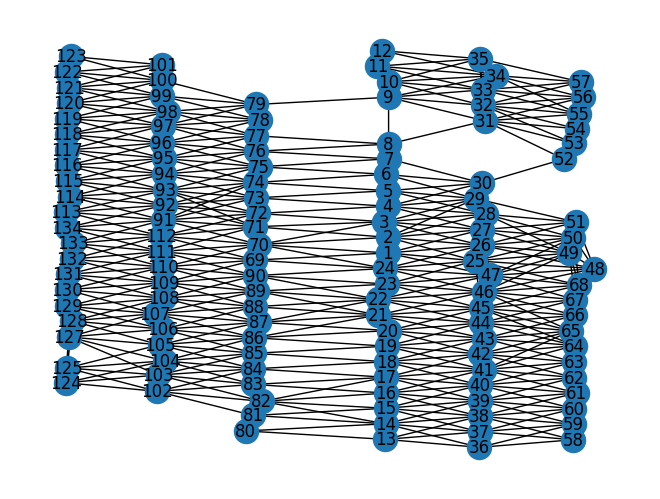

In [12]:
def construct_graph(turbine1, turbine2, radius_x, radius_y):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 < n2:
        distance = np.sqrt(((turbine2.x - turbine1.x) / radius_x)**2 + ((turbine2.y - turbine1.y) / radius_y)**2)
        if distance <= 1:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,radius_x, radius_y), axis=1),axis=1)
nx.draw(G, pos=pos_dict, labels={t: t for t in turbines_idx})

In [23]:
def Tikhonov_experiment(experiments: dict, experiment: Experiment, target_column: str):
    experiment_masks = experiments[experiment]
    for name, masks in experiment_masks.items():
        for size, mask in masks.items():
            input_data = deepcopy(datasets[name])
            input_data.loc[~mask, target_column] = np.nan
            datasets[name].loc[:,"isTest"] = input_data.isna().any(axis=1) & datasets[name].notna().all(axis=1)
            train_error, _ = tikhonov(input_data, datasets[name], G)
            print(f"{name} size {size} MSE: {train_error}")

In [14]:
random_percentages = [0.01, 0.02, 0.05, 0.1]
blackout_periods = [30, 60, 150, 300]
maintenance_periods = [1, 2, 7, 14]

In [15]:
train_masks_random = { size: mask_data(train_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }
val_masks_random = { size: mask_data(val_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }
test_masks_random = { size: mask_data(test_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }

In [16]:
train_masks_blackout = { size: mask_data(train_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }
val_masks_blackout = { size: mask_data(val_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }
test_masks_blackout = { size: mask_data(test_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }

In [17]:
train_masks_maintenance = { size: mask_data(train_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }
val_masks_maintenance = { size: mask_data(val_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }
test_masks_maintenance = { size: mask_data(test_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }

In [18]:
experiments = {
    Experiment.RANDOM: {
        "train": train_masks_random,
        "val": val_masks_random,
        "test": test_masks_random,
    },
    Experiment.BLACKOUT: {
        "train": train_masks_blackout,
        "val": val_masks_blackout,
        "test": test_masks_blackout,
    },
    Experiment.MAINTENANCE: {
        "train": train_masks_maintenance,
        "val": val_masks_maintenance,
        "test": test_masks_maintenance,
    }
}

In [19]:
target_column = "Patv"

In [24]:
Tikhonov_experiment(experiments, Experiment.RANDOM, target_column)

train size 0.01 MSE: 0.003484489396214485
train size 0.02 MSE: 0.003476646961644292
train size 0.05 MSE: 0.0035502417013049126
train size 0.1 MSE: 0.003661963390186429
val size 0.01 MSE: 0.0017814236925914884
val size 0.02 MSE: 0.001713373465463519
val size 0.05 MSE: 0.0017610077047720551
val size 0.1 MSE: 0.0017792555736377835
test size 0.01 MSE: 0.0012032428057864308
test size 0.02 MSE: 0.0011837350903078914
test size 0.05 MSE: 0.0010361018357798457
test size 0.1 MSE: 0.0010895698796957731


In [25]:
Tikhonov_experiment(experiments, Experiment.BLACKOUT, target_column)

train size 30 MSE: 0.005349527113139629
train size 60 MSE: 0.01811414398252964
train size 150 MSE: 0.0367899052798748
train size 300 MSE: 0.0446394719183445
val size 30 MSE: 0.0031557055190205574
val size 60 MSE: 0.010852232575416565
val size 150 MSE: 0.03259248286485672
val size 300 MSE: 0.04761580377817154
test size 30 MSE: 0.001336216228082776
test size 60 MSE: 0.011795250698924065
test size 150 MSE: 0.030071230605244637
test size 300 MSE: 0.036378972232341766


In [26]:
Tikhonov_experiment(experiments, Experiment.MAINTENANCE, target_column)

train size 1 MSE: 0.0564543716609478
train size 2 MSE: 0.06006365641951561
train size 7 MSE: 0.0605817511677742
train size 14 MSE: 0.06616128236055374
val size 1 MSE: 0.05690144747495651
val size 2 MSE: 0.0576503612101078
val size 7 MSE: 0.06566920876502991
val size 14 MSE: 0.08713645488023758
test size 1 MSE: 0.04370870813727379
test size 2 MSE: 0.045181598514318466
test size 7 MSE: 0.043030161410570145
test size 14 MSE: 0.05615140125155449
